__Load required functions and modules:__

In [1]:
from urllib.parse import quote
from pandas import read_csv, MultiIndex
from re import sub
from numpy import log10
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.pandas2ri import rpy2py_dataframe
from matplotlib.pyplot import subplots, style, rc
from seaborn import scatterplot, clustermap
from warnings import catch_warnings, simplefilter

deseq2 = importr("DESeq2")
style.use(["seaborn-poster", "seaborn-whitegrid"])
rc("axes", linewidth=1, edgecolor="black")
%matplotlib inline

__Construct base query:__  
RNA-Seq counts of all Mus musculus liver samples with the factor of "spaceflight" in the database; additionally, request that these samples have unnormalized counts files associated with them, which will also include the names of these files in the returned table.

In [2]:
API_ROOT = "https://visualization.genelab.nasa.gov/GLOpenAPI"

query_components = {
    "study.factor value.spaceflight": "",
    "investigation.study assays.study assay technology type": "RNA Sequencing (RNA-Seq)",
    "study.characteristics.organism": "Mus musculus",
    "study.characteristics.material type": "Liver",
    "file.datatype": "unnormalized counts",
    "format": "csv",
}

query = "&".join(f"{quote(k)}={quote(v)}" for k, v in query_components.items())
query

'study.factor%20value.spaceflight=&investigation.study%20assays.study%20assay%20technology%20type=RNA%20Sequencing%20%28RNA-Seq%29&study.characteristics.organism=Mus%20musculus&study.characteristics.material%20type=Liver&file.datatype=unnormalized%20counts&format=csv'

__Retrieve metadata:__  
the first two rows of the CSV are the header; the first three columns are the index.

In [3]:
metadata = read_csv(f"{API_ROOT}/samples/?{query}", header=[0, 1], escapechar="#")
metadata.index = MultiIndex.from_frame(metadata[["id"]])
del metadata["id"]
metadata.head()

investigation.study assays  \
                                                                                                          study assay technology type   
(id, accession) (id, assay name)                                   (id, sample name)                                                    
GLDS-168        nist-liver_transcription_profiling_RNA_Sequenci... Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep1_B2    RNA Sequencing (RNA-Seq)   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep2_B4    RNA Sequencing (RNA-Seq)   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep3_B6    RNA Sequencing (RNA-Seq)   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep4_B7    RNA Sequencing (RNA-Seq)   
                                                                   Mmus_BAL-TAL_LVR_RR3_FLT_wERCC_Rep1_F1    RNA Sequencing (RNA-Seq)   

                                                                                                          study.characteristics  \
                                                                                                                  material type   
(id, accession) (id, assay name)                                   (id, sample name)                                              
GLDS-168        nist-liver_transcription_profiling_RNA_Sequenci... Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep1_B2                 Liver   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep2_B4                 Liver   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep3_B6                 Liver   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep4_B7                 Liver   
                                                                   Mmus_BAL-TAL_LVR_RR3_FLT_wERCC_Rep1_F1                 Liver   

                                                                                                                         \
                                                                                                               organism   
(id, accession) (id, assay name)                                   (id, sample name)                                      
GLDS-168        nist-liver_transcription_profiling_RNA_Sequenci... Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep1_B2  Mus musculus   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep2_B4  Mus musculus   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep3_B6  Mus musculus   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep4_B7  Mus musculus   
                                                                   Mmus_BAL-TAL_LVR_RR3_FLT_wERCC_Rep1_F1  Mus musculus   

                                                                                                          study.factor value  \
                                                                                                                 spaceflight   
(id, accession) (id, assay name)                                   (id, sample name)                                           
GLDS-168        nist-liver_transcription_profiling_RNA_Sequenci... Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep1_B2      Basal Control   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep2_B4      Basal Control   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep3_B6      Basal Control   
                                                                   Mmus_BAL-TAL_LVR_RR3_BSL_wERCC_Rep4_B7      Basal Control   
                                                                   Mmus_BAL-TAL_

Note that this allowed us to retrieve multiple samples across _multiple datasets:_

In [4]:
metadata.index.to_frame()["id"][["accession", "sample name"]].groupby("accession").count()

,sample name
accession,
GLDS-164,6
GLDS-168,52
GLDS-47,9
GLDS-48,14


__Retrieve unnormalized counts:__  
the first _three_ rows are the header (corresponding to the index of `metadata`), the first column is the index (gene ID).  
Note that while we requested the names of unnormalized counts files, we do not need to retrieve these files directly; GLOpenAPI processes them remotely and delivers a merged counts table to the user.

In [5]:
counts = read_csv(f"{API_ROOT}/data/?{query}", header=[0, 1, 2], index_col=0, escapechar="#")
counts.head()

*                                                                     GLDS-47  \
*                  rr1-casis_transcription_profiling_RNA_Sequencing_(RNA-Seq)   
index                                             Mmus_C57-6T_LVR_BSL_Rep1_B1   
ENSMUSG00000000001                                             1983.0           
ENSMUSG00000000003                                                0.0           
ENSMUSG00000000028                                               31.0           
ENSMUSG00000000031                                               35.0           
ENSMUSG00000000037                                                0.0           

*                                                                           \
*                                                                            
index              Mmus_C57-6T_LVR_BSL_Rep2_B2 Mmus_C57-6T_LVR_BSL_Rep3_B3   
ENSMUSG00000000001                      2708.0                      2532.0   
ENSMUSG00000000003                         0.0                         0.0   
ENSMUSG00000000028                        38.0                        42.0   
ENSMUSG00000000031                        37.0                        48.0   
ENSMUSG00000000037                         0.0                         1.0   

*                                                                           \
*                                                                            
index              Mmus_C57-6T_LVR_FLT_Rep1_F1 Mmus_C57-6T_LVR_FLT_Rep2_F2   
ENSMUSG00000000001                      2504.0                      2740.0   
ENSMUSG00000000003                         0.0                         0.0   
ENSMUSG00000000028                        43.0                        39.0   
ENSMUSG00000000031                        40.0                        16.0   
ENSMUSG00000000037                         4.0                         0.0   

*                                                                          \
*                                                                           
index              Mmus_C57-6T_LVR_FLT_Rep3_F4 Mmus_C57-6T_LVR_GC_Rep1_G2   
ENSMUSG00000000001                      3207.0                     2720.0   
ENSMUSG00000000003                         0.0                        0.0   
ENSMUSG00000000028                        36.0                       50.0   
ENSMUSG00000000031                        26.0                       26.0   
ENSMUSG00000000037                         1.0                        0.0   

*                                                                         \
*                                                                          
index              Mmus_C57-6T_LVR_GC_Rep2_G3 Mmus_C57-6T_LVR_GC_Rep3_G5   
ENSMUSG00000000001                     2463.0                     3174.0   
ENSMUSG00000000003                        0.0                        0.0   
ENSMUSG00000000028                       52.0                       54.0   
ENSMUSG00000000031                       28.0                       32.0   
ENSMUSG00000000037                        0.0                        0.0   

*                                                                                              GLDS-48  \
*                  rodent_research-1_(rr1)_nasa_liver_transcription_profiling_RNA_Sequencing_(RNA-Seq)   
index                                                                   Mmus_C57-6J_LVR_FLT_C_Rep1_M25   
ENSMUSG00000000001                                             1255.0                                    
ENSMUSG00000000003                                                0.0                                    
ENSMUSG00000000028                                               12.0                                    
ENSMUSG00000000031                                               10.0                                    
ENSMUSG00000000037                                                0.0                                    

*                   ...  \

__Construct R dataframes for use in DESeq2:__  
note that we collapse multilevel indices and columns to single-level rownames and colnames for simplicity, and replace spaces with dots in factor values ("Ground Control" becomes "Ground.Control") simply to avoid R/DESeq2 throwing warnings.  
Since there are samples present from multiple studies, we will also account for it by introducing a factor "batch".

In [6]:
metadata = metadata.reindex(counts.columns)

colData = robjects.DataFrame({
    "batch": robjects.FactorVector(
        metadata.index.get_level_values(0).map(lambda s: s.replace("-", "_")),
    ),
    "spaceflight": robjects.FactorVector(
        metadata[("study.factor value", "spaceflight")].map(lambda s: s.replace(" ", ".")),
    ),
})
colData.rownames = metadata.index.map("/".join).tolist()

counts_fillna = counts.fillna(0)
countData = robjects.DataFrame({"/".join(col): robjects.IntVector(counts_fillna[col]) for col in counts_fillna})
countData.rownames = counts.index.tolist()

__Run DESeq2__ to infer differentially expressed genes between the conditions "Space Flight" and "Ground Control", convert the results back to pandas DataFrames, add custom columns:

In [7]:
analysis = deseq2.DESeq(
    deseq2.DESeqDataSetFromMatrix(
        countData=countData, colData=colData,
        design=robjects.Formula("~spaceflight+batch"),
    ),
    test="LRT", reduced=robjects.Formula("~batch"),
)

r_results = deseq2.results(
    analysis, contrast=robjects.StrVector([
        "spaceflight", "Space.Flight", "Ground.Control",
    ]),
)

results = rpy2py_dataframe(robjects.r("function(x) data.frame(x)")(r_results))
results["-log10(padj)"] = -log10(results["padj"].fillna(1))
results["significant"] = (results["padj"]<.05) & (results["log2FoldChange"].abs()>2)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 560 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



__Display the table of genes identified as significantly differentially expressed:__

In [8]:
results[results["significant"]].drop(columns=["-log10(padj)", "significant"]).sort_values(by="log2FoldChange")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000096490,4.253197,-2.629335,0.615761,26.085283,9.153208e-06,1.235335e-04
ENSMUSG00000095351,42.389562,-2.014465,0.565094,13.551140,3.584393e-03,1.603816e-02
ENSMUSG00000049252,1.207579,2.000743,1.302016,10.484232,1.486824e-02,4.849641e-02
ENSMUSG00000083070,1.145412,2.013473,0.517538,21.902540,6.834892e-05,6.700135e-04
ENSMUSG00000118203,10.702841,2.014427,0.444351,31.111709,8.052326e-07,1.565135e-05
...,...,...,...,...,...,...
ENSMUSG00000028332,5.951008,2.833538,0.754895,22.057580,6.345610e-05,6.297004e-04
ENSMUSG00000020490,4.308256,3.554023,0.846128,25.111848,1.463099e-05,1.842217e-04
ENSMUSG00000029866,3.493003,3.687375,0.773622,26.851885,6.323662e-06,9.045238e-05
ENSMUSG00000092563,3.437059,3.949610,0.734759,37.733661,3.218307e-08,9.434801e-07


__Example: render a volcano plot__

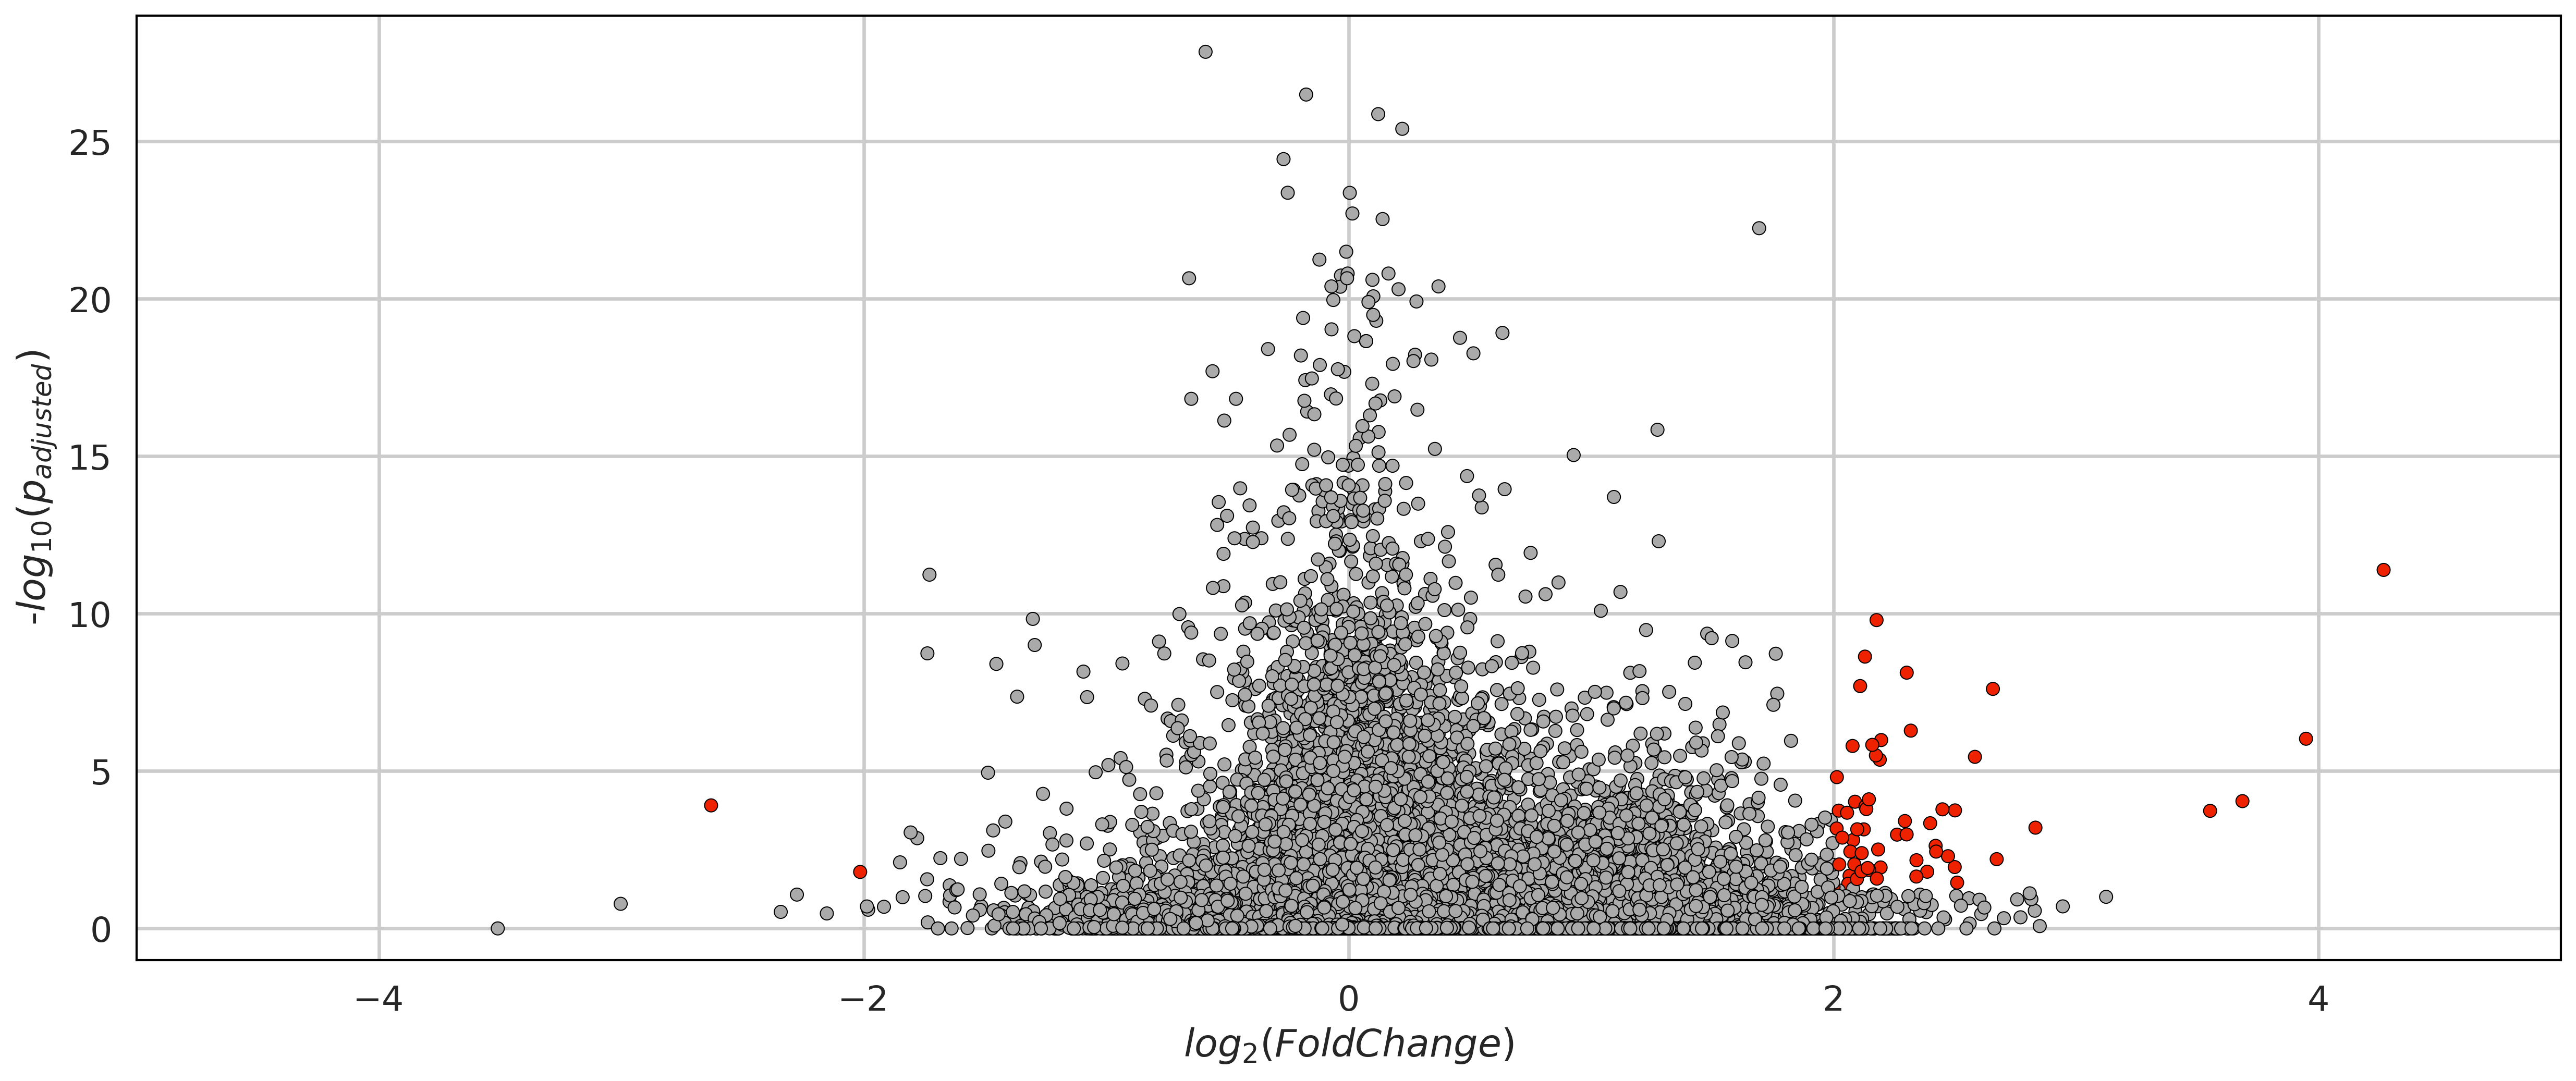

In [9]:
figure, ax = subplots(figsize=(20, 8), dpi=300)
scatterplot(
    ax=ax, data=results, x="log2FoldChange", y="-log10(padj)",
    hue="significant", palette=["#AAA", "#E20"], ec="#000", s=36,
)
ax.set(xlim=(-5, 5), ylim=(-1, 29), xlabel="$log_{2}(FoldChange)$", ylabel="-$log_{10}(p_{adjusted})$")

with catch_warnings():
    simplefilter("ignore")
    ax.legend().remove()

__Example: render a clustermap of z-scores of log-transformed normalized counts of differentially expressed genes__

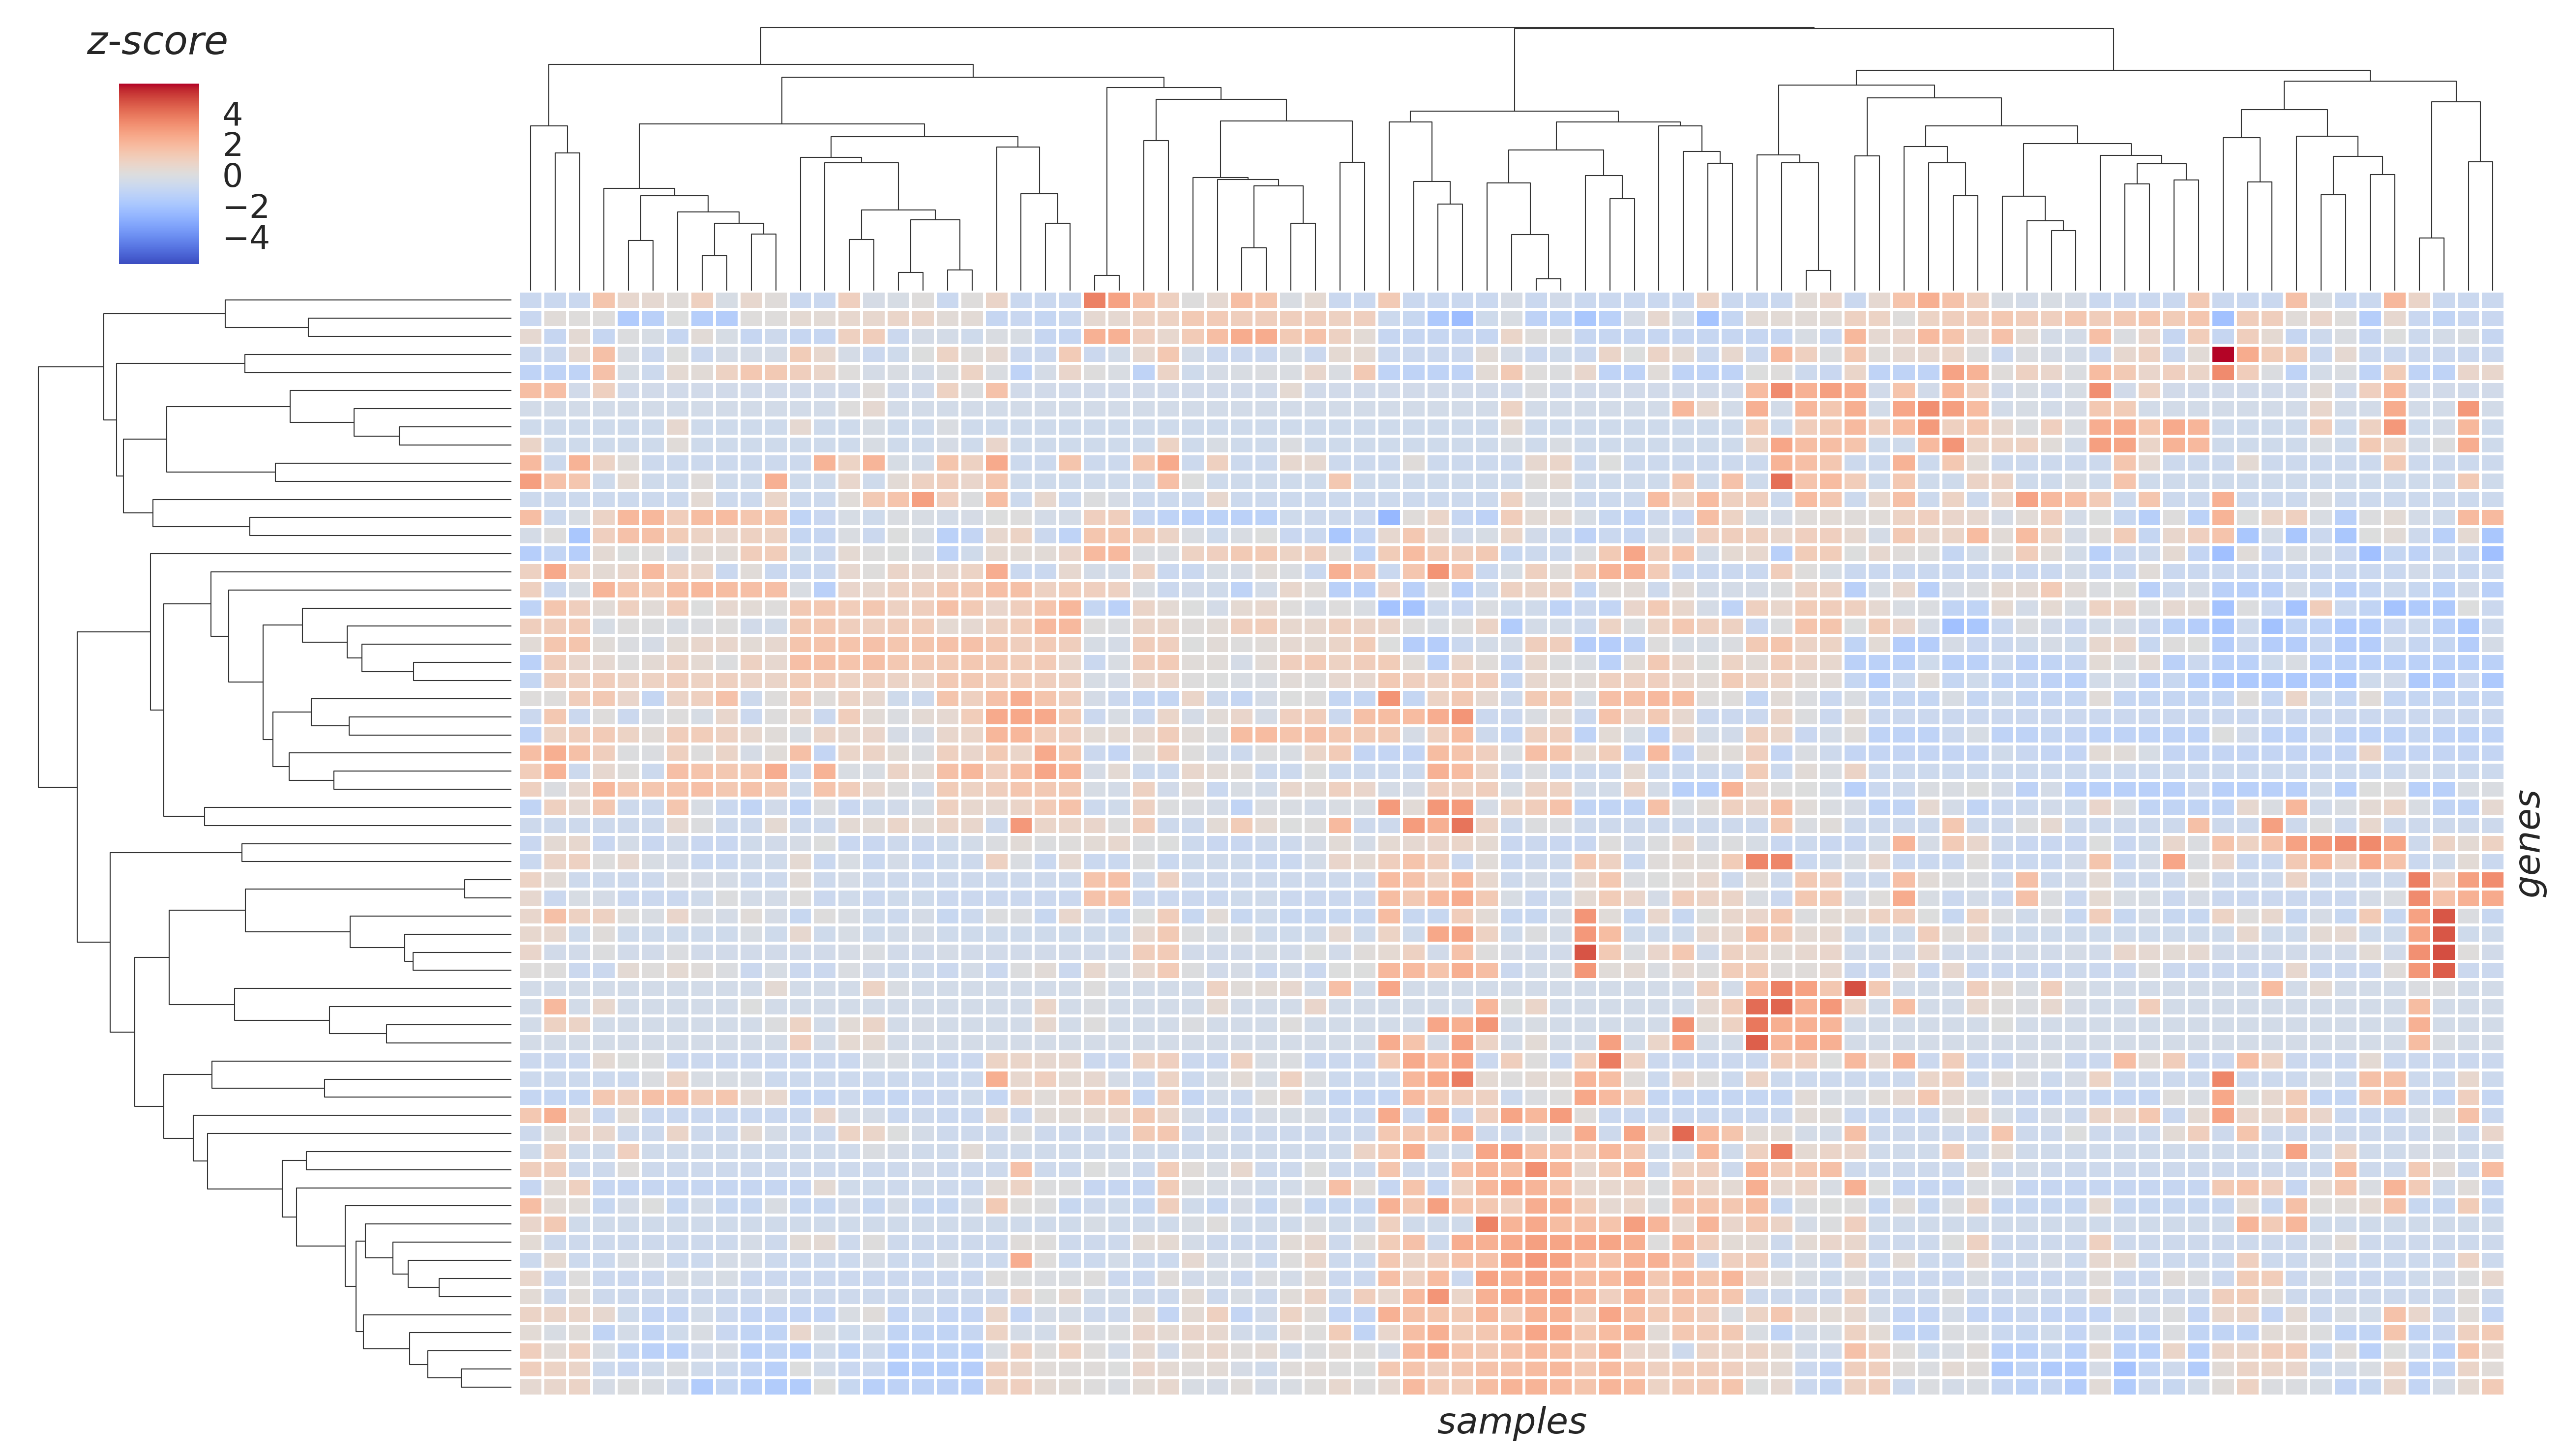

In [10]:
sigcounts = counts.reindex(results[results["significant"]].index)
lognorm_sc = log10(.1 + sigcounts / sigcounts.mean())
zlognorm_sc = lognorm_sc.sub(lognorm_sc.mean(axis=1), axis=0).div(lognorm_sc.std(axis=1), axis=0)
vmax = zlognorm_sc.abs().max().max()

g = clustermap(data=zlognorm_sc, metric="correlation", vmin=-vmax, vmax=vmax, cmap="coolwarm", lw=1, figsize=(20, 25))
g.ax_heatmap.set(xticks=[], yticks=[], xlabel="$samples$", ylabel="$genes$")
g.ax_cbar.set(xlim=(-15, 5), ylim=(-36, 7), zorder=-1, title=f"{' '*5}$z$-$score$")
g.fig.dpi = 300